<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_Gilt10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 5.51 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 15:05:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Gilt10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 8.2 MB/s 
     |████████████████████████████████| 133 kB 45.1 MB/s 
     |████████████████████████████████| 170 kB 48.7 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 138 kB 46.4 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 62 kB 704 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 0uirq4xf
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/0uirq4xf


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 9b2ul19q with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
8/8 [==============================] - 22s 169ms/step - loss: 0.1970 - mean_squared_error: 0.1970 - mean_absolute_error: 0.3845 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1815
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0671 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1631
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0535 - val_loss: 0.0514 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1961
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0766 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1494
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0029 - mean_squared_error: 0

epoch,99
loss,0.00091
mean_squared_error,0.00091
mean_absolute_error,0.02367
val_loss,0.00893
val_mean_squared_error,0.00893
val_mean_absolute_error,0.07298
_runtime,48
_timestamp,1627052783
_step,99
best_val_loss,0.0085


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▅▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▅▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▅▃▄▄▄▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3jofxk3n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 72ms/step - loss: 0.8672 - mean_squared_error: 0.8672 - mean_absolute_error: 0.5347 - val_loss: 0.0880 - val_mean_squared_error: 0.0880 - val_mean_absolute_error: 0.2551
Epoch 2/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0554 - mean_squared_error: 0.0554 - mean_absolute_error: 0.1909 - val_loss: 0.1105 - val_mean_squared_error: 0.1105 - val_mean_absolute_error: 0.2872
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0543 - mean_squared_error: 0.0543 - mean_absolute_error: 0.1808 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1917
Epoch 4/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0868 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1333
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0130 - mean_squared_

epoch,26
loss,0.00218
mean_squared_error,0.00218
mean_absolute_error,0.0363
val_loss,0.01606
val_mean_squared_error,0.01606
val_mean_absolute_error,0.10065
_runtime,18
_timestamp,1627052827
_step,26
best_val_loss,0.01343


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁
val_loss,▆█▄▂▃▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▄▂▃▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▅▂▄▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇█
_timestamp,▁▁▁▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 0nhanqje with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 5s 41ms/step - loss: 0.2659 - mean_squared_error: 0.2659 - mean_absolute_error: 0.3777 - val_loss: 0.4617 - val_mean_squared_error: 0.4617 - val_mean_absolute_error: 0.6328
Epoch 2/100
32/32 [==============================] - 1s 17ms/step - loss: 0.1031 - mean_squared_error: 0.1031 - mean_absolute_error: 0.2449 - val_loss: 0.0540 - val_mean_squared_error: 0.0540 - val_mean_absolute_error: 0.1936
Epoch 3/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - mean_absolute_error: 0.1993 - val_loss: 0.0499 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1949
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.1168 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1693
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0101 - mean_squared_

epoch,49
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02254
val_loss,0.01565
val_mean_squared_error,0.01565
val_mean_absolute_error,0.08997
_runtime,38
_timestamp,1627052872
_step,49
best_val_loss,0.01053


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▄▂▂▂▂▂▂▁▂▂▃▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 06a5skm5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 68ms/step - loss: 0.1241 - mean_squared_error: 0.1241 - mean_absolute_error: 0.2791 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1594
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0758 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1523
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0449 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1355
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0367 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1183
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0016 - mean_squared_

epoch,78
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01507
val_loss,0.00643
val_mean_squared_error,0.00643
val_mean_absolute_error,0.06222
_runtime,30
_timestamp,1627052909
_step,78
best_val_loss,0.00619


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jr3o0hcu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 129ms/step - loss: 1.2549 - mean_squared_error: 1.2549 - mean_absolute_error: 0.8192 - val_loss: 1.3179 - val_mean_squared_error: 1.3179 - val_mean_absolute_error: 1.1073
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.7480 - mean_squared_error: 0.7480 - mean_absolute_error: 0.7600 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1445
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0840 - mean_squared_error: 0.0840 - mean_absolute_error: 0.2122 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1277
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0725 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1251
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0099 - mean_squared_error: 0.

epoch,56
loss,0.02905
mean_squared_error,0.02905
mean_absolute_error,0.1417
val_loss,0.05193
val_mean_squared_error,0.05193
val_mean_absolute_error,0.18474
_runtime,26
_timestamp,1627052944
_step,56
best_val_loss,0.00607


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▁
mean_squared_error,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▁
mean_absolute_error,█▇▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▅▄▂
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▇▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: trhcpbg7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 37ms/step - loss: 0.0706 - mean_squared_error: 0.0706 - mean_absolute_error: 0.1709 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1572
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0422 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1125
Epoch 3/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0307 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0984
Epoch 4/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0283 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0940
Epoch 5/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0011 - mean_squared_error

epoch,49
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01795
val_loss,0.00874
val_mean_squared_error,0.00874
val_mean_absolute_error,0.07225
_runtime,29
_timestamp,1627052982
_step,49
best_val_loss,0.00851


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3t6v6nul with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 131ms/step - loss: 0.7872 - mean_squared_error: 0.7872 - mean_absolute_error: 0.6051 - val_loss: 0.0515 - val_mean_squared_error: 0.0515 - val_mean_absolute_error: 0.1904
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1807 - val_loss: 0.0584 - val_mean_squared_error: 0.0584 - val_mean_absolute_error: 0.2113
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0948 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1488
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1536
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0033 - mean_squared_error: 0.0033 

epoch,49
loss,0.00426
mean_squared_error,0.00426
mean_absolute_error,0.0556
val_loss,0.00873
val_mean_squared_error,0.00873
val_mean_absolute_error,0.07246
_runtime,18
_timestamp,1627053008
_step,49
best_val_loss,0.0072


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,▇█▅▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▅▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: r4mr2ko9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 3s 39ms/step - loss: 0.2062 - mean_squared_error: 0.2062 - mean_absolute_error: 0.3918 - val_loss: 0.0509 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1875
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1778 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1843
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - mean_absolute_error: 0.1641 - val_loss: 0.0460 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1803
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1378 - val_loss: 0.0425 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1742
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0208 - mean_squared_

epoch,99
loss,0.0011
mean_squared_error,0.0011
mean_absolute_error,0.0262
val_loss,0.01617
val_mean_squared_error,0.01617
val_mean_absolute_error,0.10096
_runtime,55
_timestamp,1627053081
_step,99
best_val_loss,0.01617


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: up77ymwa with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 5s 45ms/step - loss: 0.1200 - mean_squared_error: 0.1200 - mean_absolute_error: 0.2473 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1655
Epoch 2/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0456 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1340
Epoch 3/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0492 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1357
Epoch 4/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0434 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1300
Epoch 5/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0029 - mean_squared_error

epoch,49
loss,0.00141
mean_squared_error,0.00141
mean_absolute_error,0.02915
val_loss,0.00771
val_mean_squared_error,0.00771
val_mean_absolute_error,0.06737
_runtime,41
_timestamp,1627053131
_step,49
best_val_loss,0.00709


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▂▂▂▁▁▁▁▁▂
val_loss,█▆▆▅▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▄▅▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: yds4y9zb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 4s 68ms/step - loss: 23386.4088 - mean_squared_error: 23386.4088 - mean_absolute_error: 69.8609 - val_loss: 1.1914 - val_mean_squared_error: 1.1914 - val_mean_absolute_error: 0.8891
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 2.1740 - mean_squared_error: 2.1740 - mean_absolute_error: 0.7387 - val_loss: 141.3264 - val_mean_squared_error: 141.3264 - val_mean_absolute_error: 11.4383
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 48.2733 - mean_squared_error: 48.2733 - mean_absolute_error: 4.8442 - val_loss: 19.0167 - val_mean_squared_error: 19.0167 - val_mean_absolute_error: 4.3045
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 151.7867 - mean_squared_error: 151.7867 - mean_absolute_error: 10.2702 - val_loss: 9.5704 - val_mean_squared_error: 9.5704 - val_mean_absolute_error: 2.7593
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss:

epoch,16
loss,0.18842
mean_squared_error,0.18842
mean_absolute_error,0.31203
val_loss,3.77967
val_mean_squared_error,3.77967
val_mean_absolute_error,1.89409
_runtime,13
_timestamp,1627053162
_step,16
best_val_loss,0.22571


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,▃▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
mean_squared_error,▃▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
mean_absolute_error,▆▁▁▂▁▃▂▁▁█▁▁▂▂▁▂▁
val_loss,▁█▂▁▂▃▁▂▂▁▄▃▁▃▂▁▁
val_mean_squared_error,▁█▂▁▂▃▁▂▂▁▄▃▁▃▂▁▁
val_mean_absolute_error,▁█▃▃▄▅▁▃▃▂▆▄▃▅▄▁▂
_runtime,▁▂▂▂▂▄▄▄▅▅▅▅▇▇▇▇█
_timestamp,▁▂▂▂▂▄▄▄▅▅▅▅▇▇▇▇█
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: va40od9n with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 5s 40ms/step - loss: 0.7559 - mean_squared_error: 0.7559 - mean_absolute_error: 0.4694 - val_loss: 0.1022 - val_mean_squared_error: 0.1022 - val_mean_absolute_error: 0.2689
Epoch 2/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - mean_absolute_error: 0.1949 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1650
Epoch 3/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0821 - val_loss: 0.0649 - val_mean_squared_error: 0.0649 - val_mean_absolute_error: 0.2154
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.1008 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1582
Epoch 5/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0098 - mean_squared_error

epoch,29
loss,0.05135
mean_squared_error,0.05135
mean_absolute_error,0.18873
val_loss,0.05675
val_mean_squared_error,0.05675
val_mean_absolute_error,0.19846
_runtime,28
_timestamp,1627053200
_step,29
best_val_loss,0.01136


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▂▂▂▂▂▂▂
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▂▂▂▂▂▂▂
mean_absolute_error,█▄▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▄▅▅▅▅▅▅▅▅▅
val_loss,█▃▅▃▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▅▄▅▄▄▄▄▄▄▄
val_mean_squared_error,█▃▅▃▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▅▄▅▄▄▄▄▄▄▄
val_mean_absolute_error,█▄▆▄▂▂▂▁▁▂▁▁▁▁▁▃▁▁▂▁▅▅▅▅▅▅▅▅▅▅
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇███
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: l08e2njw with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 130ms/step - loss: 1.3035 - mean_squared_error: 1.3035 - mean_absolute_error: 0.7989 - val_loss: 0.1700 - val_mean_squared_error: 0.1700 - val_mean_absolute_error: 0.3612
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.3263 - mean_squared_error: 0.3263 - mean_absolute_error: 0.4829 - val_loss: 0.1303 - val_mean_squared_error: 0.1303 - val_mean_absolute_error: 0.3169
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0667 - mean_squared_error: 0.0667 - mean_absolute_error: 0.2208 - val_loss: 0.0787 - val_mean_squared_error: 0.0787 - val_mean_absolute_error: 0.2405
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - mean_absolute_error: 0.1927 - val_loss: 0.1751 - val_mean_squared_error: 0.1751 - val_mean_absolute_error: 0.3831
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0909 - mean_squared_error: 0.

epoch,99
loss,0.0011
mean_squared_error,0.0011
mean_absolute_error,0.0269
val_loss,0.00627
val_mean_squared_error,0.00627
val_mean_absolute_error,0.0616
_runtime,28
_timestamp,1627053239
_step,99
best_val_loss,0.00569


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 63gl6y8y with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 125ms/step - loss: 0.4601 - mean_squared_error: 0.4601 - mean_absolute_error: 0.5343 - val_loss: 0.0672 - val_mean_squared_error: 0.0672 - val_mean_absolute_error: 0.2230
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 1.4787 - mean_squared_error: 1.4787 - mean_absolute_error: 0.8130 - val_loss: 479.5530 - val_mean_squared_error: 479.5530 - val_mean_absolute_error: 21.8666
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss

epoch,10
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,9
_timestamp,1627053258
_step,10
best_val_loss,0.06723


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,▁█
mean_squared_error,▁█
mean_absolute_error,▁█
val_loss,▁█
val_mean_squared_error,▁█
val_mean_absolute_error,▁█
_runtime,▁▅▅▅▅▅▅████
_timestamp,▁▅▅▅▅▅▅████
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: p8z7b25c with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 4s 130ms/step - loss: 0.1420 - mean_squared_error: 0.1420 - mean_absolute_error: 0.3022 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1489
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0829 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1430
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0754 - val_loss: 0.0355 - val_mean_squared_error: 0.0355 - val_mean_absolute_error: 0.1412
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0854 - val_loss: 0.0350 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1400
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0080 - mean_squared_error: 0.0080 

epoch,49
loss,0.00356
mean_squared_error,0.00356
mean_absolute_error,0.04879
val_loss,0.01331
val_mean_squared_error,0.01331
val_mean_absolute_error,0.08971
_runtime,18
_timestamp,1627053285
_step,49
best_val_loss,0.01331


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▃▁▂▂▃▁▂▂▂▂▂▂▂▂▂
val_loss,█████▇▆▇▆▅▇▅▆▅▄▄▄▄▄▃▃▄▂▃▃▂▁▂▁▂▂▂▂▁▂▁▁▁▂▁
val_mean_squared_error,█████▇▆▇▆▅▇▅▆▅▄▄▄▄▄▃▃▄▂▃▃▂▁▂▁▂▂▂▂▁▂▁▁▁▂▁
val_mean_absolute_error,█▇▇▇▇▆▆▆▅▅▆▅▆▅▄▄▄▄▄▄▄▄▃▃▃▂▂▂▁▂▂▁▂▁▂▁▁▁▂▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cwarsue9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 73ms/step - loss: 0.5755 - mean_squared_error: 0.5755 - mean_absolute_error: 0.5961 - val_loss: 0.2904 - val_mean_squared_error: 0.2904 - val_mean_absolute_error: 0.5028
Epoch 2/100
16/16 [==============================] - 0s 23ms/step - loss: 0.1116 - mean_squared_error: 0.1116 - mean_absolute_error: 0.2496 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1779
Epoch 3/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1642 - val_loss: 0.0498 - val_mean_squared_error: 0.0498 - val_mean_absolute_error: 0.1905
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0991 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1406
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0070 - mean_squared_

epoch,46
loss,0.00224
mean_squared_error,0.00224
mean_absolute_error,0.03423
val_loss,0.01106
val_mean_squared_error,0.01106
val_mean_absolute_error,0.08291
_runtime,27
_timestamp,1627053322
_step,46
best_val_loss,0.00789


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▃▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▃▁▁▁▁▁
mean_absolute_error,█▅▄▂▂▂▄▂▂▁▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▅▂▁▁▁▁
val_loss,▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁
val_mean_squared_error,▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁
val_mean_absolute_error,▆▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: chqnmkx0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 4s 41ms/step - loss: 7304.5545 - mean_squared_error: 7304.5545 - mean_absolute_error: 49.2058 - val_loss: 5.4598 - val_mean_squared_error: 5.4598 - val_mean_absolute_error: 2.2826
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 19.4707 - mean_squared_error: 19.4707 - mean_absolute_error: 3.8869 - val_loss: 8.3606 - val_mean_squared_error: 8.3606 - val_mean_absolute_error: 2.7939
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 853.5972 - mean_squared_error: 853.5972 - mean_absolute_error: 10.3337 - val_loss: 0.9949 - val_mean_squared_error: 0.9949 - val_mean_absolute_error: 0.8668
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 7.4787 - mean_squared_error: 7.4787 - mean_absolute_error: 1.7518 - val_loss: 527.0789 - val_mean_squared_error: 527.0789 - val_mean_absolute_error: 22.9358
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 167

epoch,19
loss,274.48798
mean_squared_error,274.48798
mean_absolute_error,9.65384
val_loss,11.51518
val_mean_squared_error,11.51518
val_mean_absolute_error,3.37029
_runtime,19
_timestamp,1627053353
_step,19
best_val_loss,0.05552


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▃▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁█▁▁▁
mean_squared_error,▃▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁█▁▁▁
mean_absolute_error,▆▂▄▁▂▃▂▃▂▁▂▁▃▂▂▁█▁▂▃
val_loss,▁▁▁▂▁▁█▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▂▁▁█▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▄▁▂█▁▂▁▃▁▁▂▁▁▁▁▁▁
_runtime,▁▂▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇██
_timestamp,▁▂▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 4zpelt9y with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 5s 44ms/step - loss: 1.3648 - mean_squared_error: 1.3648 - mean_absolute_error: 0.7805 - val_loss: 0.6130 - val_mean_squared_error: 0.6130 - val_mean_absolute_error: 0.7339
Epoch 2/50
32/32 [==============================] - 1s 19ms/step - loss: 0.1837 - mean_squared_error: 0.1837 - mean_absolute_error: 0.3276 - val_loss: 0.0845 - val_mean_squared_error: 0.0845 - val_mean_absolute_error: 0.2340
Epoch 3/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0538 - mean_squared_error: 0.0538 - mean_absolute_error: 0.1857 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1409
Epoch 4/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1129 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0896
Epoch 5/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0014 - mean_squared_error

epoch,41
loss,0.00069
mean_squared_error,0.00069
mean_absolute_error,0.02074
val_loss,0.00722
val_mean_squared_error,0.00722
val_mean_absolute_error,0.06675
_runtime,39
_timestamp,1627053409
_step,41
best_val_loss,0.00617


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,▄▂▁▁▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆█▁▁▁▁▁▁▁
mean_squared_error,▄▂▁▁▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆█▁▁▁▁▁▁▁
mean_absolute_error,▆▃▂▁▁▁▁▃▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅█▂▁▁▁▁▁▁
val_loss,▂▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▂▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: qj6n3z35 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 4s 41ms/step - loss: 0.5015 - mean_squared_error: 0.5015 - mean_absolute_error: 0.3883 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1649
Epoch 2/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0486 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1577
Epoch 3/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0547 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1225
Epoch 4/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0363 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1061
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0013 - mean_squared_error

epoch,49
loss,0.00113
mean_squared_error,0.00113
mean_absolute_error,0.02667
val_loss,0.00585
val_mean_squared_error,0.00585
val_mean_absolute_error,0.05861
_runtime,36
_timestamp,1627053468
_step,49
best_val_loss,0.00557


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▇▅▄▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,██▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▂▂▂▂▁▁▁▁▂▁▁▁▁▃▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nhydsxvz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 119ms/step - loss: 0.1403 - mean_squared_error: 0.1403 - mean_absolute_error: 0.3140 - val_loss: 0.0359 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1626
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0740 - val_loss: 0.0651 - val_mean_squared_error: 0.0651 - val_mean_absolute_error: 0.2223
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1243 - val_loss: 0.0616 - val_mean_squared_error: 0.0616 - val_mean_absolute_error: 0.1906
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - mean_absolute_error: 0.1313 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1357
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0187 - mean_squared_error: 0.

epoch,46
loss,0.00542
mean_squared_error,0.00542
mean_absolute_error,0.06183
val_loss,0.01972
val_mean_squared_error,0.01972
val_mean_absolute_error,0.10681
_runtime,15
_timestamp,1627053506
_step,46
best_val_loss,0.01666


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▃▃▂▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▂▂▂
val_loss,▄█▇▃▃▃▇▄▃▂▃▃▄▂▃▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▃▂▁▁
val_mean_squared_error,▄█▇▃▃▃▇▄▃▂▃▃▄▂▃▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▃▂▁▁
val_mean_absolute_error,▅█▆▃▃▃▇▃▃▂▃▃▄▂▃▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▃▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 31c8aohs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 37ms/step - loss: 0.1846 - mean_squared_error: 0.1846 - mean_absolute_error: 0.3611 - val_loss: 0.0545 - val_mean_squared_error: 0.0545 - val_mean_absolute_error: 0.1962
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1728 - val_loss: 0.0469 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1818
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1475 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1763
Epoch 4/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1240 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1776
Epoch 5/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0141 - mean_squared_error

epoch,49
loss,0.00181
mean_squared_error,0.00181
mean_absolute_error,0.03298
val_loss,0.02536
val_mean_squared_error,0.02536
val_mean_absolute_error,0.12662
_runtime,31
_timestamp,1627053558
_step,49
best_val_loss,0.02536


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vz7d19kx with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 114ms/step - loss: 252.3607 - mean_squared_error: 252.3607 - mean_absolute_error: 9.6316 - val_loss: 91.1928 - val_mean_squared_error: 91.1928 - val_mean_absolute_error: 9.5172
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 214.7879 - mean_squared_error: 214.7879 - mean_absolute_error: 11.7029 - val_loss: 36.6355 - val_mean_squared_error: 36.6355 - val_mean_absolute_error: 4.1417
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 138.0004 - mean_squared_error: 138.0004 - mean_absolute_error: 8.4530 - val_loss: 23.2973 - val_mean_squared_error: 23.2973 - val_mean_absolute_error: 4.7065
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 37.9762 - mean_squared_error: 37.9762 - mean_absolute_error: 5.7632 - val_loss: 61.3198 - val_mean_squared_error: 61.3198 - val_mean_absolute_error: 7.7698
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 29.2197 

epoch,14
loss,4.94244
mean_squared_error,4.94244
mean_absolute_error,1.85066
val_loss,4.06484
val_mean_squared_error,4.06484
val_mean_absolute_error,1.93739
_runtime,10
_timestamp,1627053597
_step,14
best_val_loss,0.19835


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,██▄▃▂▂▂▁▁▁▂▁▁▁▁
val_loss,█▄▃▆▁▁▃▂▁▂▁▁▁▂▁
val_mean_squared_error,█▄▃▆▁▁▃▂▁▂▁▁▁▂▁
val_mean_absolute_error,█▄▄▇▁▁▄▄▁▃▂▁▁▃▂
_runtime,▁▁▁▁▅▅▅▅▅██████
_timestamp,▁▁▁▁▅▅▅▅▅██████
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: g8qr8ceh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 61ms/step - loss: 0.1404 - mean_squared_error: 0.1404 - mean_absolute_error: 0.3067 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1777
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.1029 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1729
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0522 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1670
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0501 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1670
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error

epoch,49
loss,0.00087
mean_squared_error,0.00087
mean_absolute_error,0.02311
val_loss,0.01378
val_mean_squared_error,0.01378
val_mean_absolute_error,0.09288
_runtime,22
_timestamp,1627053633
_step,49
best_val_loss,0.01378


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,███▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: thddslat with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 5s 42ms/step - loss: 0.3727 - mean_squared_error: 0.3727 - mean_absolute_error: 0.4074 - val_loss: 0.0459 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1838
Epoch 2/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0856 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0807
Epoch 3/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1337 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1016
Epoch 4/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0445 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0834
Epoch 5/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0214 - mean_squared_

epoch,54
loss,0.00062
mean_squared_error,0.00062
mean_absolute_error,0.01932
val_loss,0.00722
val_mean_squared_error,0.00722
val_mean_absolute_error,0.06714
_runtime,43
_timestamp,1627053693
_step,54
best_val_loss,0.00612


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁
mean_squared_error,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁
mean_absolute_error,▄▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁
val_loss,▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁
val_mean_squared_error,▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁
val_mean_absolute_error,▄▁▂▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: goa4tziu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 121ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan 

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,11
_timestamp,1627053717
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▅▅▅▅▅▅█
_timestamp,▁▁▁▅▅▅▅▅▅█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: p37afr8f with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 123ms/step - loss: 43530.1768 - mean_squared_error: 43530.1768 - mean_absolute_error: 100.4767 - val_loss: 3.0853 - val_mean_squared_error: 3.0853 - val_mean_absolute_error: 1.2705
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 5.8452 - mean_squared_error: 5.8452 - mean_absolute_error: 1.3077 - val_loss: 0.9140 - val_mean_squared_error: 0.9140 - val_mean_absolute_error: 0.7712
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 1.4192 - mean_squared_error: 1.4192 - mean_absolute_error: 0.7789 - val_loss: 0.6160 - val_mean_squared_error: 0.6160 - val_mean_absolute_error: 0.5845
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 7.0795 - mean_squared_error: 7.0795 - mean_absolute_error: 1.2973 - val_loss: 362.3813 - val_mean_squared_error: 362.3813 - val_mean_absolute_error: 19.0313
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 210.9003 - mean_

epoch,15
loss,94.38788
mean_squared_error,94.38788
mean_absolute_error,5.29534
val_loss,1.01756
val_mean_squared_error,1.01756
val_mean_absolute_error,0.83479
_runtime,12
_timestamp,1627053739
_step,15
best_val_loss,0.207


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▁▁▂▃▁▁▁▁▁▃▁
val_loss,▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▂▁▁▁█▁▁▁▁▁▂▂▁
_runtime,▁▁▃▃▃▃▃▆▆▆▆▆▆▆██
_timestamp,▁▁▃▃▃▃▃▆▆▆▆▆▆▆██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: cb5rqw9b with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 5s 41ms/step - loss: 113.1808 - mean_squared_error: 113.1808 - mean_absolute_error: 7.6437 - val_loss: 10.7364 - val_mean_squared_error: 10.7364 - val_mean_absolute_error: 3.2247
Epoch 2/50
32/32 [==============================] - 1s 19ms/step - loss: 40.9069 - mean_squared_error: 40.9069 - mean_absolute_error: 5.0395 - val_loss: 29.1256 - val_mean_squared_error: 29.1256 - val_mean_absolute_error: 5.3850
Epoch 3/50
32/32 [==============================] - 1s 18ms/step - loss: 33.5119 - mean_squared_error: 33.5119 - mean_absolute_error: 4.7395 - val_loss: 5.1178 - val_mean_squared_error: 5.1178 - val_mean_absolute_error: 1.7903
Epoch 4/50
32/32 [==============================] - 1s 17ms/step - loss: 20.6223 - mean_squared_error: 20.6223 - mean_absolute_error: 3.6197 - val_loss: 26.9359 - val_mean_squared_error: 26.9359 - val_mean_absolute_error: 5.1860
Epoch 5/50
32/32 [==============================] - 1s 18ms/step - loss: 20.2765 - m

epoch,41
loss,0.00553
mean_squared_error,0.00553
mean_absolute_error,0.05076
val_loss,0.02335
val_mean_squared_error,0.02335
val_mean_absolute_error,0.12813
_runtime,35
_timestamp,1627053785
_step,41
best_val_loss,0.00869


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▄▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▇▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▂▇▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▃█▂▂▂▂▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 6t57v0b6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 125ms/step - loss: 0.2212 - mean_squared_error: 0.2212 - mean_absolute_error: 0.4113 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1595
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0606 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1602
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0589 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1532
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0479 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1513
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0044 - mean_squared_error: 0.

epoch,56
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02765
val_loss,0.01255
val_mean_squared_error,0.01255
val_mean_absolute_error,0.0865
_runtime,23
_timestamp,1627053820
_step,56
best_val_loss,0.01046


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▂▂▁▁▁▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▆▄▄▃▄▃▃▃▂▂▃▂▂▃▂▃▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇▆▆▄▄▃▄▃▃▃▂▂▃▂▂▃▂▃▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▆▄▄▃▄▃▃▄▃▂▄▂▂▃▂▃▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j8ax6t2z with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 4s 39ms/step - loss: 0.1175 - mean_squared_error: 0.1175 - mean_absolute_error: 0.2688 - val_loss: 0.0359 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1543
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0500 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1315
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0313 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0976
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0250 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0917
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0010 - mean_squared_

epoch,53
loss,0.00046
mean_squared_error,0.00046
mean_absolute_error,0.0166
val_loss,0.00709
val_mean_squared_error,0.00709
val_mean_absolute_error,0.06469
_runtime,36
_timestamp,1627053872
_step,53
best_val_loss,0.00706


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▆▃▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▂▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vh250am0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 70ms/step - loss: 1.3001 - mean_squared_error: 1.3001 - mean_absolute_error: 0.6476 - val_loss: 0.0553 - val_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.1937
Epoch 2/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0733 - mean_squared_error: 0.0733 - mean_absolute_error: 0.1904 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1535
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.1086 - mean_squared_error: 0.1086 - mean_absolute_error: 0.2414 - val_loss: 0.0494 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1850
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1373 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1706
Epoch 5/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0122 - mean_squared_

epoch,47
loss,0.00208
mean_squared_error,0.00208
mean_absolute_error,0.03732
val_loss,0.01293
val_mean_squared_error,0.01293
val_mean_absolute_error,0.08621
_runtime,28
_timestamp,1627053911
_step,47
best_val_loss,0.01076


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▁▂▁▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▇▅▄▆▃▃▃▂▂▂▃▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁
val_mean_squared_error,█▅▇▅▄▆▃▃▃▂▂▂▃▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁
val_mean_absolute_error,█▆▇▇▅▇▃▃▃▂▃▂▃▂▂▂▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▂▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: c9q6ohnm with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 3s 35ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_er

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,12
_timestamp,1627053938
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▃▃▃▆▆███
_timestamp,▁▁▃▃▃▆▆███
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ti4hcywz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 63ms/step - loss: 0.1616 - mean_squared_error: 0.1616 - mean_absolute_error: 0.3405 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1488
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0925 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1564
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0582 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1387
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0384 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1334
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0021 - mean_squared_error

epoch,49
loss,0.00046
mean_squared_error,0.00046
mean_absolute_error,0.0164
val_loss,0.00796
val_mean_squared_error,0.00796
val_mean_absolute_error,0.06975
_runtime,25
_timestamp,1627053975
_step,49
best_val_loss,0.00755


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mppu0tmc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 65ms/step - loss: 0.2460 - mean_squared_error: 0.2460 - mean_absolute_error: 0.4404 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - val_mean_absolute_error: 0.3360
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.1632 - mean_squared_error: 0.1632 - mean_absolute_error: 0.3449 - val_loss: 0.0927 - val_mean_squared_error: 0.0927 - val_mean_absolute_error: 0.2409
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0905 - mean_squared_error: 0.0905 - mean_absolute_error: 0.2349 - val_loss: 0.0547 - val_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.1934
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - mean_absolute_error: 0.1780 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1841
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0446 - mean_squared_

epoch,99
loss,0.00205
mean_squared_error,0.00205
mean_absolute_error,0.03507
val_loss,0.02801
val_mean_squared_error,0.02801
val_mean_absolute_error,0.134
_runtime,39
_timestamp,1627054029
_step,99
best_val_loss,0.02801


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ek34eehi with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 140ms/step - loss: 0.2217 - mean_squared_error: 0.2217 - mean_absolute_error: 0.4098 - val_loss: 0.0576 - val_mean_squared_error: 0.0576 - val_mean_absolute_error: 0.1986
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0552 - mean_squared_error: 0.0552 - mean_absolute_error: 0.1883 - val_loss: 0.0714 - val_mean_squared_error: 0.0714 - val_mean_absolute_error: 0.2224
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - mean_absolute_error: 0.2008 - val_loss: 0.0503 - val_mean_squared_error: 0.0503 - val_mean_absolute_error: 0.1877
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1805 - val_loss: 0.0487 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1844
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0424 - mean_squared_error: 0.

epoch,99
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02678
val_loss,0.01642
val_mean_squared_error,0.01642
val_mean_absolute_error,0.10099
_runtime,31
_timestamp,1627054083
_step,99
best_val_loss,0.01642


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xjgu5oxb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 40ms/step - loss: 0.0986 - mean_squared_error: 0.0986 - mean_absolute_error: 0.2494 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1482
Epoch 2/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0583 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1321
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0392 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1291
Epoch 4/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0368 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1275
Epoch 5/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0021 - mean_squared_error

epoch,49
loss,0.00061
mean_squared_error,0.00061
mean_absolute_error,0.01933
val_loss,0.00943
val_mean_squared_error,0.00943
val_mean_absolute_error,0.07586
_runtime,35
_timestamp,1627054131
_step,49
best_val_loss,0.00943


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: aubojr8i with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 133ms/step - loss: 0.8482 - mean_squared_error: 0.8482 - mean_absolute_error: 0.6167 - val_loss: 0.1130 - val_mean_squared_error: 0.1130 - val_mean_absolute_error: 0.3004
Epoch 2/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0930 - mean_squared_error: 0.0930 - mean_absolute_error: 0.2647 - val_loss: 0.0820 - val_mean_squared_error: 0.0820 - val_mean_absolute_error: 0.2504
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0528 - mean_squared_error: 0.0528 - mean_absolute_error: 0.1930 - val_loss: 0.0688 - val_mean_squared_error: 0.0688 - val_mean_absolute_error: 0.2245
Epoch 4/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0586 - mean_squared_error: 0.0586 - mean_absolute_error: 0.2047 - val_loss: 0.0519 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1738
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0480 - mean_squared_error: 0.0480 

epoch,33
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02764
val_loss,0.01087
val_mean_squared_error,0.01087
val_mean_absolute_error,0.0807
_runtime,20
_timestamp,1627054177
_step,33
best_val_loss,0.0094


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▄▅▄▄▃▁▁▁▁
val_loss,▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▁▁▁▁▁
val_mean_squared_error,▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▁▁▁▁▁
val_mean_absolute_error,▄▃▃▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▃▃▁▁▁▁▁
_runtime,▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v5h40fsp with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 68ms/step - loss: 0.2732 - mean_squared_error: 0.2732 - mean_absolute_error: 0.4019 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1011
Epoch 2/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0437 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0921
Epoch 3/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0365 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0869
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0362 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0764
Epoch 5/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0011 - mean_squared_error

epoch,41
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01757
val_loss,0.00677
val_mean_squared_error,0.00677
val_mean_absolute_error,0.06233
_runtime,24
_timestamp,1627054215
_step,41
best_val_loss,0.00601


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▂▁▁▁
val_loss,▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄█▃▂▁▁▁
val_mean_squared_error,▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄█▃▂▁▁▁
val_mean_absolute_error,▄▃▃▂▂▃▂▂▁▂▂▁▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▅█▃▂▂▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: cq91k8r8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 78ms/step - loss: 0.1018 - mean_squared_error: 0.1018 - mean_absolute_error: 0.2360 - val_loss: 0.0477 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1877
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0695 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1785
Epoch 3/100
16/16 [==============================] - 0s 25ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0654 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1814
Epoch 4/100
16/16 [==============================] - 0s 27ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0881 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1414
Epoch 5/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0052 - mean_squared_

epoch,69
loss,0.00119
mean_squared_error,0.00119
mean_absolute_error,0.02715
val_loss,0.0084
val_mean_squared_error,0.0084
val_mean_absolute_error,0.07195
_runtime,39
_timestamp,1627054268
_step,69
best_val_loss,0.00792


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▂▁▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▁▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▂▃▂▃▂▃▃▂▂▁▁▂▃▁▁▂▃▂▂▂▂▃▁▁▂▁▂▁▁▂▁▁▁▁▁▁▂
val_loss,█▇▅▄▃▃▃▂▂▂▂▃▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▃▂▂▂▂▃▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▃▃▃▂▃▂▂▄▃▂▂▂▁▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3e47dwsn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 5s 48ms/step - loss: 0.2031 - mean_squared_error: 0.2031 - mean_absolute_error: 0.3159 - val_loss: 0.0881 - val_mean_squared_error: 0.0881 - val_mean_absolute_error: 0.2583
Epoch 2/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1143 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1411
Epoch 3/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0938 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1316
Epoch 4/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0858 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1384
Epoch 5/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0162 - mean_squared_

epoch,38
loss,0.00112
mean_squared_error,0.00112
mean_absolute_error,0.02653
val_loss,0.01362
val_mean_squared_error,0.01362
val_mean_absolute_error,0.08627
_runtime,39
_timestamp,1627054328
_step,38
best_val_loss,0.00996


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▁▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▂▁▂▁▁▁▁
val_loss,█▃▃▃▂▃▅▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▃▅▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▃▅▃▂▂▁▃▁▂▁▁▂▁▁▃▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nbvpj827 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 4s 44ms/step - loss: 21021.2820 - mean_squared_error: 21021.2820 - mean_absolute_error: 53.0419 - val_loss: 4.3329 - val_mean_squared_error: 4.3329 - val_mean_absolute_error: 1.7864
Epoch 2/100
32/32 [==============================] - 1s 17ms/step - loss: 71.4906 - mean_squared_error: 71.4906 - mean_absolute_error: 5.8585 - val_loss: 0.4645 - val_mean_squared_error: 0.4645 - val_mean_absolute_error: 0.5681
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 413.9795 - mean_squared_error: 413.9795 - mean_absolute_error: 7.5375 - val_loss: 0.1788 - val_mean_squared_error: 0.1788 - val_mean_absolute_error: 0.3474
Epoch 4/100
32/32 [==============================] - 1s 18ms/step - loss: 66.2164 - mean_squared_error: 66.2164 - mean_absolute_error: 2.8448 - val_loss: 2.8480 - val_mean_squared_error: 2.8480 - val_mean_absolute_error: 1.4917
Epoch 5/100
32/32 [==============================] - 1s 16ms/step - loss: 54.69

epoch,32
loss,16.06978
mean_squared_error,16.06978
mean_absolute_error,1.52445
val_loss,0.10359
val_mean_squared_error,0.10359
val_mean_absolute_error,0.25484
_runtime,30
_timestamp,1627054380
_step,32
best_val_loss,0.05172


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁▂▁▂▁▁▆▁▁▂▁▁▂▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁▂▁▂▁▁▆▁▁▂▁▁▂▁▁▁
mean_absolute_error,█▂▄▃▃▁▃▂▄▃▁▁▆▁▁▁▄▂▆▂▃▂▁▇▂▁▅▁▁▃▂▁▁
val_loss,▁▁▁▁▃▁▁▅▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁█▁▁▁▂▃▁▁▁
val_mean_squared_error,▁▁▁▁▃▁▁▅▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁█▁▁▁▂▃▁▁▁
val_mean_absolute_error,▂▁▁▂▅▁▁▆▅▃▃▃▁▁▃▁▁▂▁▁▁▁▁▁█▁▁▂▄▄▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: tag8ywi6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 76ms/step - loss: 0.1638 - mean_squared_error: 0.1638 - mean_absolute_error: 0.3364 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1580
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0954 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1552
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0575 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1541
Epoch 4/100
16/16 [==============================] - 0s 25ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0450 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1433
Epoch 5/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0022 - mean_squared_

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'relu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
40/40 [==============================] - 2s 7ms/step - loss: 0.3195
Epoch 2/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 3/50
40/40 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 4/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 5/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 6/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 7/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 8/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 9/50
40/40 [==============================] - 0s 8ms/step - loss: 7.8078e-04
Epoch 10/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 11/50
40/40 [==============================] - 0s 8ms/step - loss: 8.9305e-04
Epoch 12/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 13/50
40/40 [======================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

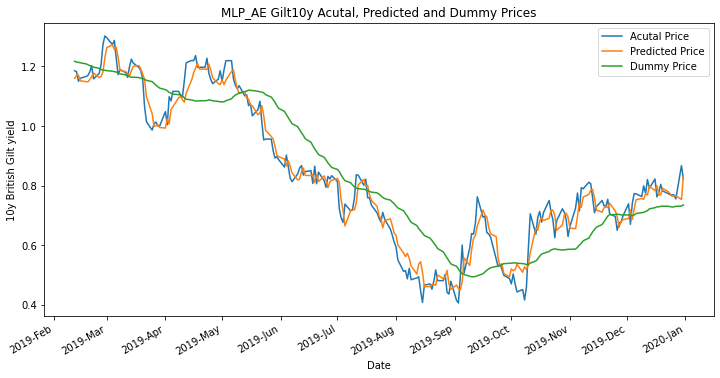

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

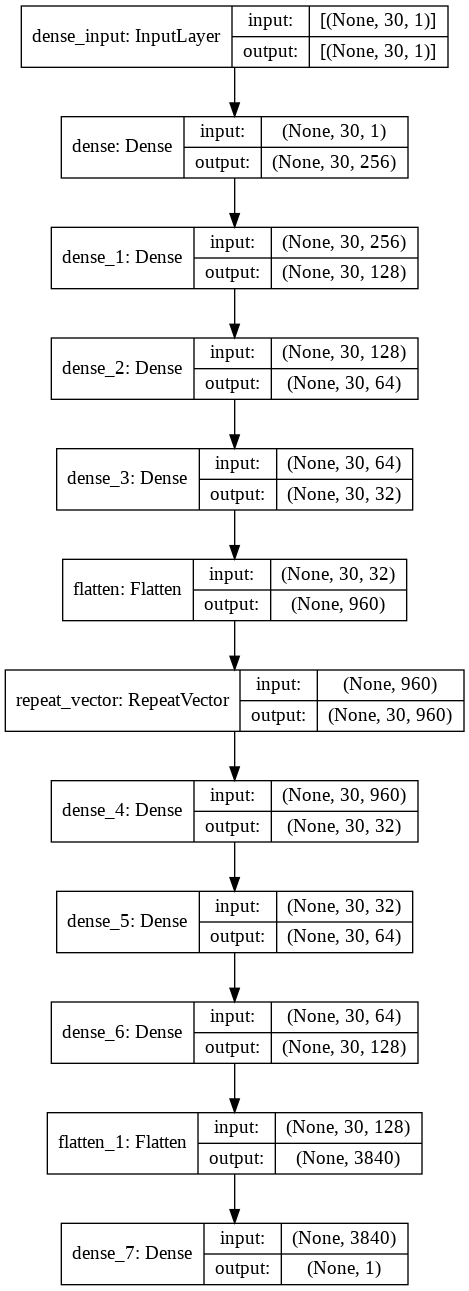

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.003395832638928879
RMSE:  0.05827377316536899
MAE:  0.04682825830112516
Dummy MSE:  0.013891737694778073
Dummy RMSE:  0.11786321603782103
Dummy MAE:  0.09977998323101281


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_Gilt10y/assets
